# SVCCA - Singular Vector Canonical Correlation Analysis

Paper: https://arxiv.org/abs/1706.05806

Code taken from: https://github.com/google/svcca

In [1]:
import numpy as np
from cca_core import get_cca_similarity

# Toy Example of CCA in action

# assume X_fake has 100 neurons and we have their activations on 1000 datapoints
A_fake = np.random.randn(100, 2000)
# Y_fake has 50 neurons with activations on the same 1000 datapoints
# Note X and Y do *not* have to have the same number of neurons
B_fake = np.random.randn(50, 2000)

# computing CCA simliarty between X_fake, Y_fake
# We expect similarity should be very low, because the fake activations are not correlated
results = get_cca_similarity(A_fake, B_fake, verbose=False)
results.keys()

dict_keys(['coef_x', 'invsqrt_xx', 'full_coef_x', 'full_invsqrt_xx', 'coef_y', 'invsqrt_yy', 'full_coef_y', 'full_invsqrt_yy', 'neuron_means1', 'neuron_means2', 'cca_coef1', 'cca_coef2', 'x_idxs', 'y_idxs', 'mean', 'sum'])

In [2]:
results["mean"][0]

0.21406758733184408

In [3]:
np.mean(results["cca_coef1"])

0.20830279673166618

## Centered kernel analysis

In [4]:
from cross_lingual_subnets.cka import cka

In [5]:
import numpy as np

# Compare the representations of 2 networks
# One has 8 layers and 300 dimensional encodings
# The other has 10 layers and 300 dimensional encodings
# Both evaluated on the same 1k examples
repr1 = np.random.randn(8, 1000, 300)
repr2 = np.random.randn(10, 1000, 300)

In [6]:
cka_results = dict()
for i, layer_reprs1 in enumerate(repr1):
    res = []
    for layer_reprs2 in repr2:
        res.append(cka(layer_reprs1, layer_reprs2))
    cka_results[i] = res

In [7]:
import pandas as pd

df = pd.DataFrame(cka_results)
df = df.sort_index(ascending=False)

[Text(0.5, 23.52222222222222, 'Layer'), Text(50.722222222222214, 0.5, 'Layer')]

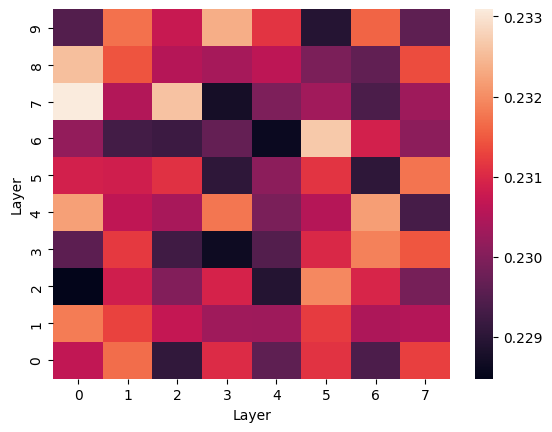

In [8]:
import seaborn as sns

ax = sns.heatmap(df)
ax.set(xlabel="Layer", ylabel="Layer")

## Full model cross-lingual representation similarity

Similarity of full vs full model one language:
- take finetuned model representation of english, full model representation of english
- over layers, compute SVCCA and CKA scores
- do this for a english and other language pairs

In [2]:
import torch

full_sub = {
    "en": {
        "base": torch.load("data/encodings/xlmr_base/en.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/en.pt"),
        "sub": torch.load("data/encodings/en_sub_mlm_finetuned/en.pt"),
    },
    "es": {
        "base": torch.load("data/encodings/xlmr_base/es.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/es.pt"),
        "sub": torch.load("data/encodings/es_sub_mlm_finetuned/es.pt"),
    },
    "ar": {
        "base": torch.load("data/encodings/xlmr_base/ar.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/ar.pt"),
        "sub": torch.load("data/encodings/ar_sub_mlm_finetuned/ar.pt"),
    },
    "de": {
        "base": torch.load("data/encodings/xlmr_base/de.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/de.pt"),
        "sub": torch.load("data/encodings/de_sub_mlm_finetuned/de.pt"),
    },
    "hi": {
        "base": torch.load("data/encodings/xlmr_base/hi.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/hi.pt"),
        "sub": torch.load("data/encodings/hi_sub_mlm_finetuned/hi.pt"),
    },
    "ru": {
        "base": torch.load("data/encodings/xlmr_base/ru.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/ru.pt"),
        "sub": torch.load("data/encodings/ru_sub_mlm_finetuned/ru.pt"),
    },
    "zh": {
        "base": torch.load("data/encodings/xlmr_base/zh.pt"),
        "full": torch.load("data/encodings/xlmr_mlm_finetuned/zh.pt"),
        "sub": torch.load("data/encodings/zh_sub_mlm_finetuned/zh.pt"),
    },
}

In [7]:
from cross_lingual_subnets.cka import cka
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def cka_cross_layer(repr1, repr2, xlabel: str, ylabel: str, title:str =None, savename: str = None):
    cka_results = dict()
    for i in range(len(repr1)):
        layer_reprs1 = repr1[i].detach()
        res = []
        for j in range(len(repr2)):
            layer_reprs2 = repr2[j].detach()
            res.append(cka(layer_reprs1, layer_reprs2))
        cka_results[i] = res

    df = pd.DataFrame(cka_results)
    df = df.sort_index(ascending=False)

    ax = sns.heatmap(df)
    ax.set(xlabel=f"{xlabel} Layer", ylabel=f"{ylabel} Layer")
    if title is not None:
        ax.set(title=title)
    if savename is not None:
        plt.savefig(f"images/{savename}")

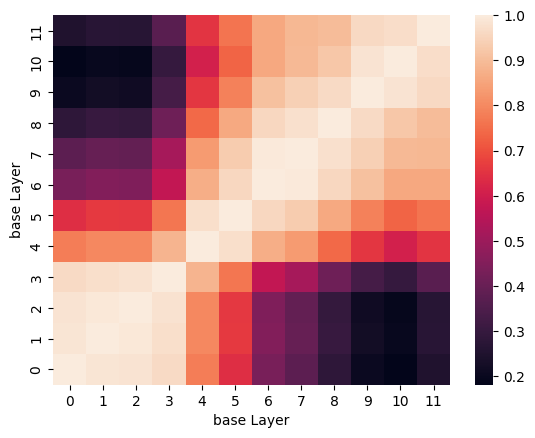

In [5]:
# Sanity check: is the same model similar to itself?
cka_cross_layer(
    full_sub["en"]["base"], full_sub["en"]["base"], xlabel="base", ylabel="base"
)

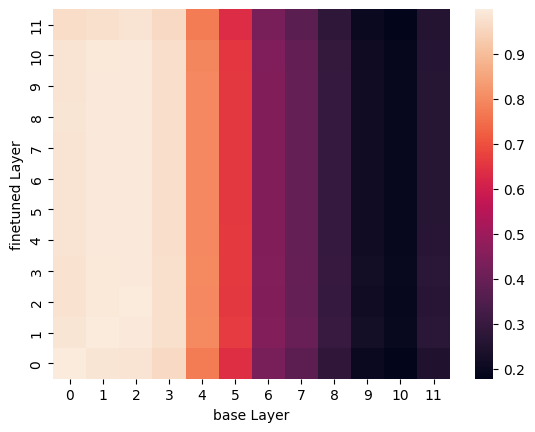

In [12]:
cka_cross_layer(
    full_sub["en"]["base"],
    full_sub["en"]["full"],
    xlabel="Base",
    ylabel="Finetuned",
    savename="cka_base_vs_finetuned.pdf",
)

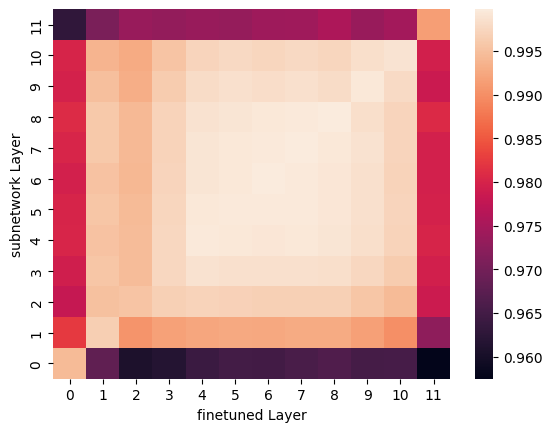

In [14]:
cka_cross_layer(
    full_sub["en"]["full"],
    full_sub["en"]["sub"],
    xlabel="finetuned",
    ylabel="subnetwork",
    savename="cka_en_full_vs_sub.pdf",
)

## Language representation similarity

TODO:
Similarity of full vs pruned model cross languages:
- take finetuned model representation of english, pruned model representation of spanish
- over layers, compute SVCCA and CKA scores
- do this for a english and other language pairs

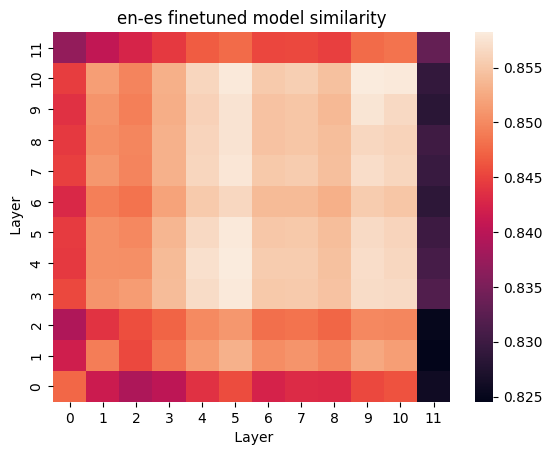

In [8]:
cka_cross_layer(
    full_sub["en"]["full"],
    full_sub["es"]["full"],
    xlabel="",
    ylabel="",
    title="en-es finetuned model similarity",
    savename="cka_en_es_finetuned.pdf",
)

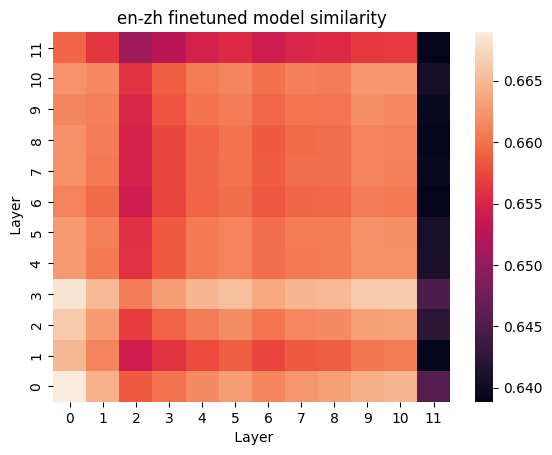

In [10]:
cka_cross_layer(
    full_sub["en"]["full"],
    full_sub["zh"]["full"],
    xlabel="",
    ylabel="",
    title="en-zh finetuned model similarity",
    savename="cka_en_zh_finetuned.pdf",
)

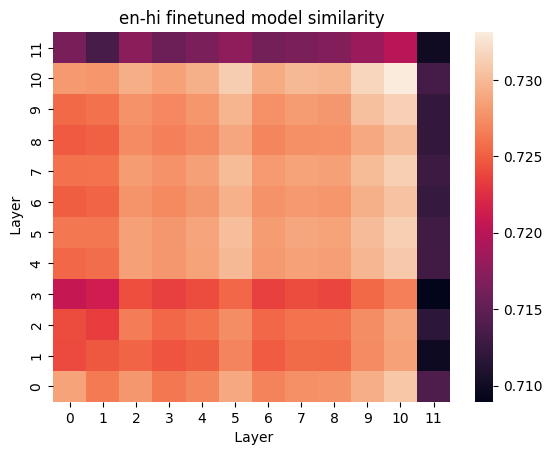

In [11]:
cka_cross_layer(
    full_sub["en"]["full"],
    full_sub["hi"]["full"],
    xlabel="",
    ylabel="",
    title="en-hi finetuned model similarity",
    savename="cka_en_hi_finetuned.pdf",
)

In [15]:
from cca_core import get_cca_similarity


def svcca_cross_layer(
    repr1, repr2, xlabel: str = None, ylabel: str = None, savename: str = None
):
    cka_results = dict()
    for i in range(len(repr1)):
        # Input must be number of neurons (encoding dim?) by datapoints
        layer_reprs1 = repr1[i].detach().T
        res = []
        for j in range(len(repr2)):
            layer_reprs2 = repr2[j].detach().T
            score = get_cca_similarity(layer_reprs1, layer_reprs2, verbose=False)[
                "mean"
            ][0]
            res.append(score)
        cka_results[i] = res

    df = pd.DataFrame(cka_results)
    df = df.sort_index(ascending=False)

    ax = sns.heatmap(df)
    if xlabel is not None and ylabel is not None:
        ax.set(xlabel=f"{xlabel} layer", ylabel=f"{ylabel} layer")
    if savename is not None:
        plt.savefig(f"images/{savename}")

In [16]:
# svcca_cross_layer(en_xlmr_base, en_xlmr_finetuned, xlabel="base", ylabel="finetuned", savename="svcca_base_vs_finetuned.pdf")

In [24]:
def cka_layer_by_layer(full_sub: dict, savename: str = None, title: str = None):
    cka_results = dict()
    for lang, vals in full_sub.items():
        full = vals["full"]
        sub = vals["sub"]

        res = []
        for layer_id in range(len(full)):
            res.append(cka(full[layer_id].detach(), sub[layer_id].detach()))
        cka_results[lang] = res

    df = pd.DataFrame(cka_results)

    sns.lineplot(data=df, markers=True)
    plt.grid()
    plt.xticks(range(12))
    plt.title(title)
    plt.xlabel("Layers")
    plt.ylabel("CKA Similarity")
    if savename is not None:
        plt.savefig(f"images/{savename}")

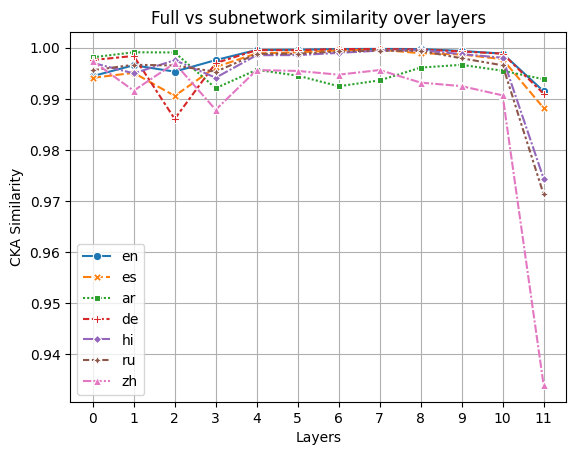

In [25]:
cka_layer_by_layer(
    full_sub=full_sub,
    savename="cka_full_vs_sub.pdf",
    title="Full vs subnetwork similarity over layers",
)

## Similarity scores over layers for different languages

In [21]:
def cka_layer_by_layer_langs(full_sub: dict,  exp_name1: str, exp_name2: str,source: str = "en", savename: str = None, title: str = None):
    cka_results = dict()
    source_vals = full_sub[source][exp_name1]
    for lang, vals in full_sub.items():
        if lang == source:
            continue

        ref_vals = vals[exp_name2]

        res = []
        for layer_id in range(len(ref_vals)):
            res.append(cka(source_vals[layer_id].detach(), ref_vals[layer_id].detach()))
        cka_results[f"{source}-{lang}"] = res

    df = pd.DataFrame(cka_results)

    sns.lineplot(data=df, markers=True)
    plt.grid()
    plt.xticks(range(12))
    plt.title(title)
    plt.xlabel("Layers")
    plt.ylabel("CKA Similarity")
    if savename is not None:
        plt.savefig(f"images/{savename}")

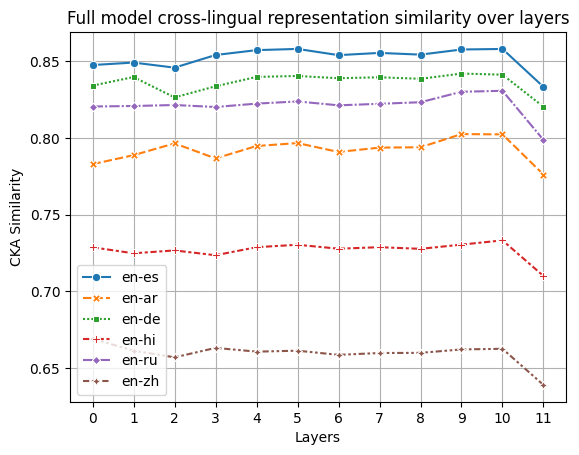

In [22]:
cka_layer_by_layer_langs(
    full_sub=full_sub,
    source="en",
    exp_name1="full",
    exp_name2="full",
    savename="cka_en_other_langs_full.pdf",
    title="Full model cross-lingual representation similarity over layers",
)

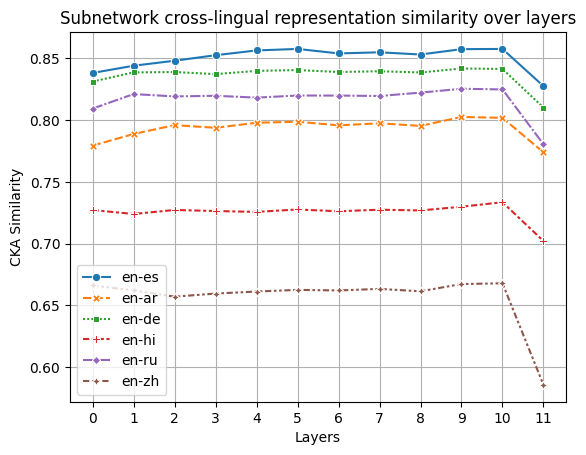

In [23]:
cka_layer_by_layer_langs(
    full_sub=full_sub,
    source="en",
    exp_name1="full",
    exp_name2="sub",
    savename="cka_en_other_langs_sub.pdf",
    title="Subnetwork cross-lingual representation similarity over layers",
)

## Heatmaps of representations base vs finetuned models for different languages

In [68]:
def cka_cross_layer_all_languages(
    full_sub: dict,
    xlabel: str,
    ylabel: str,
    exp_name1: str,
    exp_name2: str,
    savename: str = None,
):
    languages = full_sub.keys()
    fig, axs = plt.subplots(
        round(len(languages) / 2), 2, figsize=(7, 13)
    )
    axs = axs.reshape(-1)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i, (lang, preds) in enumerate(full_sub.items()):
        cka_results = dict()

        for k in range(len(preds[exp_name1])):
            layer_reprs1 = preds[exp_name1][k].detach()
            res = []
            for j in range(len(preds[exp_name2])):
                layer_reprs2 = preds[exp_name2][j].detach()
                res.append(cka(layer_reprs1, layer_reprs2))
            cka_results[k] = res

        df = pd.DataFrame(cka_results)
        df = df.sort_index(ascending=False)

        ax = sns.heatmap(df, ax=axs[i], cbar=i == 0, cbar_ax=None if i else cbar_ax)
        ax.set(title=lang)

    # Delete the last unused subplot
    if len(languages) % 2 != 0:
        fig.delaxes(axs[-1])

    fig.tight_layout(rect=[0, 0, .9, 1])

    if savename is not None:
        plt.savefig(f"images/{savename}")

/scratch-local/scur0251/ipykernel_2824616/2405449026.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


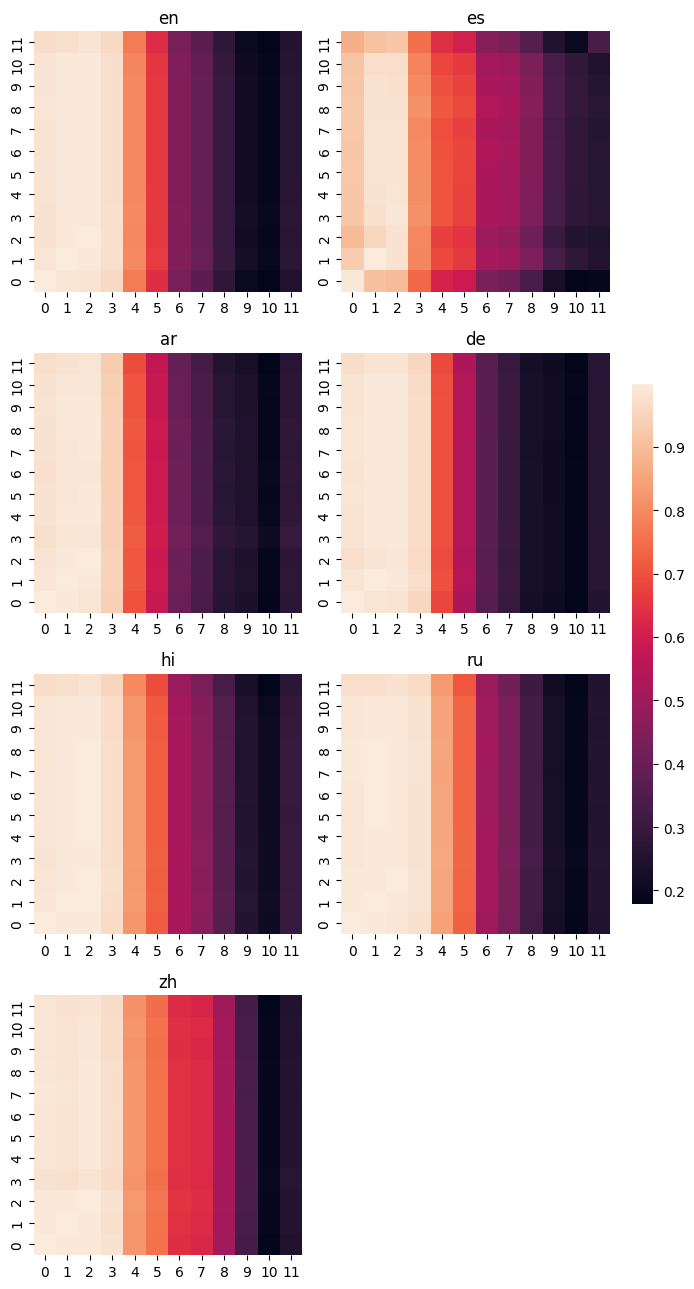

In [69]:
cka_cross_layer_all_languages(
    full_sub=full_sub,
    xlabel="Base",
    ylabel="Full",
    exp_name1="base",
    exp_name2="full",
    savename="cka_base_vs_finetuned_all_langs.pdf",
)

## Heatmaps of representations finetuned models vs subnetworks different languages

/scratch-local/scur0251/ipykernel_2824616/2405449026.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


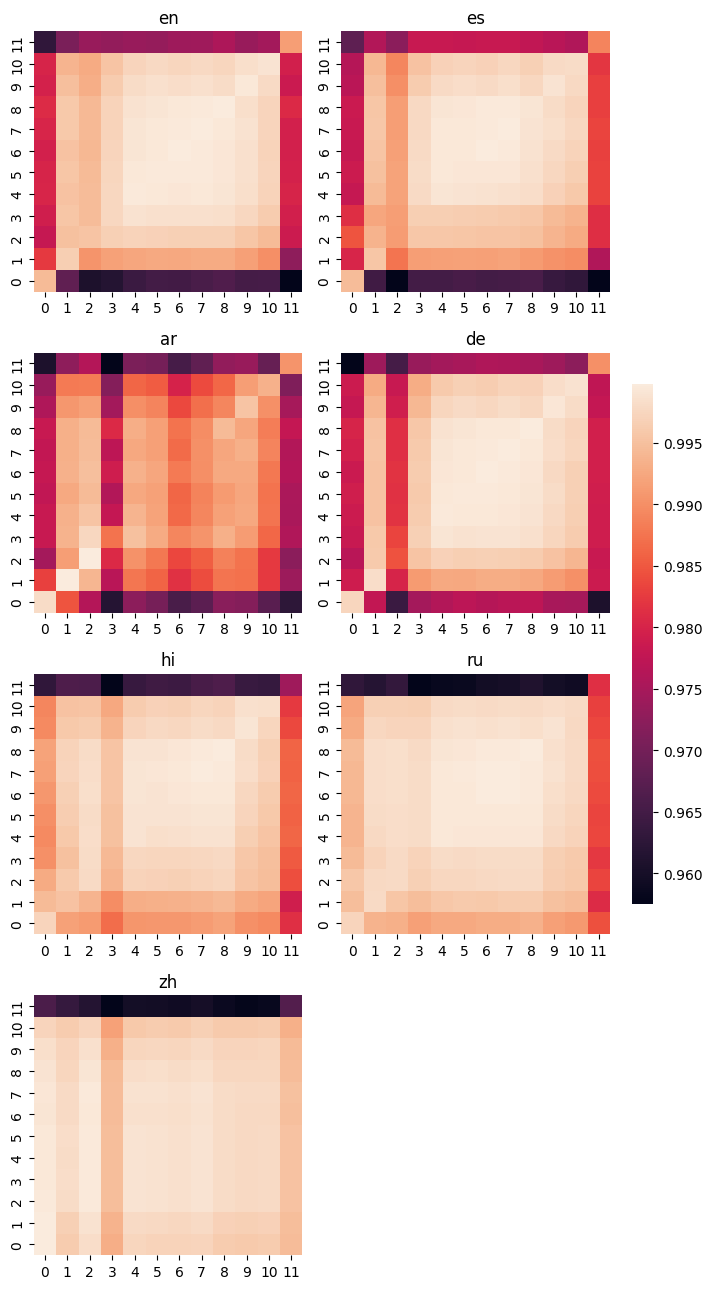

In [70]:
cka_cross_layer_all_languages(
    full_sub=full_sub,
    xlabel="Full",
    ylabel="Subnetwork",
    exp_name1="full",
    exp_name2="sub",
    savename="cka_full_vs_sub_all_langs.pdf",
)